In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

# Read data and build subnetwork

In [2]:
def get_yeastract_data(yeastract_csv_filename, gene_to_orf_filename="tftoorf.csv", as_orf=False):
    '''
    Returns Yeastract network data as a pandas DataFrame.
    '''
    def tf_to_gene(tf_name):
        '''
        Removes trailing "p" from transcription factor name and turn into uppercase.
        '''
        if tf_name[-1] == 'p':
            return tf_name.upper()[:-1]
        else:
            return tf_name
    
    yeastract_data = pd.read_csv(yeastract_csv_filename, sep= ";")
    gene_to_orf_df = pd.read_csv(gene_to_orf_filename)
    
    tf_list = list(yeastract_data['6855'])
    gene_list = list(yeastract_data.columns.values)[1:]
    
    # Fix dataframe so it has right things as rownames.
    yeastract_data = yeastract_data.rename(index=yeastract_data['6855'])
    yeastract_data = yeastract_data.iloc[:, 1:]
    
    tf_list = [tf_to_gene(tf) for tf in tf_list]
    if as_orf:
        gene_to_orf = dict(zip(list(gene_to_orf_df.iloc[:,0]), list(gene_to_orf_df.iloc[:,2])))
        
        rownames = [gene_to_orf[tf] for tf in tf_list]
        # Change to TF if possible, otherwise keep same name.
        colnames = [gene_to_orf.get(gene, gene) for gene in gene_list]
    else:
        rownames = tf_list
        colnames = gene_list
    
    final_data = pd.DataFrame(np.array(yeastract_data), index=rownames, columns=colnames)
    
    return final_data

def get_gasch_data(gasch_data_filename="complete_dataset_gasch.txt", 
                   orf_to_gene_filename="orfname_time_course_fixed.csv",
                   supset=None ,
                   as_orf=False):
    '''
    Returns heat shock time-course data from Gasch as DataFrame.
    '''
    gasch_data = pd.read_csv(gasch_data_filename, sep="\t")
#    gasch_data = gasch_data.iloc[:,:11] # Filter only heat-shock data from first experiment (hs-1).
    
    if not as_orf:
        # Rename as genes.
        orf_to_gene_df = pd.read_csv(orf_to_gene_filename)
        orfs = list(orf_to_gene_df.iloc[:,0])
        genes = list(orf_to_gene_df.iloc[:,3])
        
        # Remove unknowns, keep original name.
        genes = [gene if gene != 'Unknown' else orfs[i] for i, gene in enumerate(genes)]
        orf_to_gene = dict(zip(orfs, genes))
        
        orf_list = list(gasch_data["UID"])
        gene_names = [orf_to_gene.get(orf, orf) for orf in orf_list]
        #print(gene_names)
        gasch_data["UID"] = gene_names
        gasch_data = gasch_data.rename(index=gasch_data["UID"])
        gasch_data = gasch_data.iloc[:, 1:]
        if supset != None:
            to_delete = set(gene_names)-set(supset)
            to_delete_list = list(to_delete)
            gasch_data = gasch_data.drop(to_delete_list)
    return gasch_data
    

def squarify(df, sort=False):
    '''
    Turns Yeastract DataFrame into a square dataframe (i.e. adjacency matrix).
    '''
    cols=list(df.columns)
    rows=list(df.index)
    d = []
    for x in cols:
        if x in rows:
            d.append(list(df.loc[x]))
        else:
            d.append([0]*len(cols))
    A = np.array(d)
    return pd.DataFrame(A, index=cols, columns=cols)

def reorder(target_orf, adj_matrix):
    A = target_orf #input the list of target orf name
    B = adj_matrix #input the adj matrix

    #First we want to extract the header from the adj matrix and compare them with the list

    B_header = list(B)

    AB_diff = list(set(B_header) - set(A))
    #print(set(A)<set(B_header))
    A_total = A + AB_diff
    B = B[A_total]
    B = B.reindex(A_total)
    return B

In [3]:
# Read network data.
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)
#gasch_esr = get_gasch_data("figure3_gasch_paper.cdt","orfname_time_course_fixed.csv",cols)

In [4]:
def get_neighbors_subnetwork(network_act, network_inh, starters):
    '''
    network_act: Network of activators, network of inhibitors.
    
    Returns activator and inhibitor networks with starter nodes and direct downstream neighbors
    (whether activators or inhibitors).
    '''
    neighbors = []
    for tf in starters:
        neighbors.extend(list(network_act.successors(tf)))
        neighbors.extend(list(network_inh.successors(tf)))
      
    all_nodes = starters + neighbors
    # Remove duplicates.
    all_nodes = list(set(all_nodes))
    return network_act.subgraph(all_nodes), network_inh.subgraph(all_nodes)

In [5]:
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))
names = list(Aa)

network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

Since we're using different constants, we need to get the activator and inhibitor networks separately.

In [6]:
#These transcription factors are the ones we expect to turn on the heat shock response.
heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]

G1_act, G1_inh = get_neighbors_subnetwork(network_act, network_inh, heat_shock_starters)

In [7]:
G1_act2, G1_inh2 = get_neighbors_subnetwork(network_act, network_inh, list(G1_act.nodes()))

In [8]:
len(G1_act2.nodes())

1727

### Model definition for heat shock subnetwork

In [9]:
# Get activator and inhibitor matrices for subnetwork.
Aa_hsf = nx.adjacency_matrix(G1_act).toarray()
Ai_hsf = nx.adjacency_matrix(G1_inh).toarray()

# Take transpose to match what we need for modeling.
Aa_hsf, Ai_hsf = Aa_hsf.transpose(), Ai_hsf.transpose()

In [10]:
# Get activator and inhibitor matrices for subnetwork.
Aa_hsf2 = nx.adjacency_matrix(G1_act2).toarray()
Ai_hsf2 = nx.adjacency_matrix(G1_inh2).toarray()

# Take transpose to match what we need for modeling.
Aa_hsf2, Ai_hsf2 = Aa_hsf2.transpose(), Ai_hsf2.transpose()

In [11]:
len(Aa_hsf2)

1727

In [12]:
len(Ai_hsf2)

1727

In [13]:
nodes = list(set(list(G1_act2.nodes()) + list(G1_inh2.nodes())))

In [14]:
# Model 1: mRNA only, separate inhibition and activation.
def f(y, t0, u, ka, ki, kf, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return A @ y - kf * y + u

# Model 2: mRNA only, separate inhibition and activation, max activation (tanh).
def f2(y, t0, u, ka, ki, kf, k_max, k_width, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return k_max * np.tanh((A @ y) / k_width) - kf * y + u

# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, ka, ki, kf, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = (A @ p) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

# Model 4: mRNA and protein, separate inhibition and activation, max activation (tanh).
def f4(y, t0, u, ka, ki, kf, k_max, k_width, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = k_max * np.tanh(A @ p / k_width) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

### Brief model test

This is just a test to see if the modifications I did to the model change anything or not.

#### Ka and Ki

In [18]:
u = 0.05 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_act2.nodes()])
y0 = [0.0] * len(Aa_hsf2)
times = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

kf = [0.1] * len(Aa_hsf2)
y = odeint(f, y0=y0, t=times, args=(u, 0.3, 0.3, kf, Aa_hsf2, Ai_hsf2))

KeyboardInterrupt: 

In [ ]:
nodes = list(G1_act2.nodes())
hsf_index = nodes.index("HSF1")

In [ ]:
real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

### Protein model.

In [15]:
u = 0.03 * np.array([1.0 if node in heat_shock_starters else 0.0 for node in G1_act.nodes()])
y0 = [0.0] * len(Aa_hsf) * 2
times = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

kf = [0.1] * len(Aa_hsf)
k_prot = 0.08
y = odeint(f3, y0=y0, t=times, args=(u, 0.3, 0.3, kf, k_prot, Aa_hsf, Ai_hsf))

In [16]:
real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

NameError: name 'hsf_index' is not defined

OK, so this seems to be working. Now let's try and do the error function.

In [49]:
def error(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, Aa_hsf, Ai_hsf))
    
    # Return mean absolute error.
    return np.nanmedian(np.abs(y - y_data))

def error2(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.
    
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width = params[-5:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f2, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, k_max, k_width, Aa_hsf, Ai_hsf))
    
    # Return mean absolute error.
    return np.nanmean(np.abs(y - y_data))

def error3(params, y_data, N, hss_indices, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.

    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_prot = params[-4:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, ka, ki, kf, k_prot, Aa_hsf, Ai_hsf))
    m = y[:,:N]
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

In [ ]:
def error_by_glist(func, y_data, y_pred, indices):
    '''
    func is the error function
    glist is a boolean list for gene being considered or not, the index should match the y_data
    '''
    
    return func(y_data[:,indices], y_pred[:,indices])

def mad(y_data, y_pred):
    return np.nanmean(np.abs(y_data - y_pred))

## Test error function

First, we need to get the real data in a format we can use.

In [24]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
y_data = np.array(y_data).transpose()

In [34]:
N

955

In [40]:
N = len(nodes)
hss_indices = [nodes.index(tf) for tf in heat_shock_starters]
params = np.array([0.05] * 5 + [0.1] * 5 + [0.3, 0.3, 0.1])

In [41]:
hss_indices

[296, 676, 530, 881, 250]

In [44]:
errors = error(params, y_data, N, hss_indices, n_hss=5)

In [28]:
hsf_index

296

In [48]:
fit_params = minimize(error, x0=params,
                  args=(y_data, N, hss_indices, 5),
                  bounds=[(0.01, 5)] * len(params))

KeyboardInterrupt: 

In [ ]:
fit_params.x

In [244]:
fit_params2 = minimize(error2, x0=np.array([0.02, 0.1, 0.3, 0.3, 0.1, 1, 1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0.01, 5),
                          (0, 5),
                          (0, 5)])

/home/mauricio/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [255]:
fit_params2

      fun: 1.2402297693900686
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.47277762e-05,   1.76303416e-05,  -2.22044605e-08,
        -2.61546340e-03,   3.46300766e-04,  -2.81596968e-04,
         2.93498559e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 912
      nit: 38
   status: 0
  success: True
        x: array([ 1.9368709 ,  3.81454556,  5.        ,  0.03345208,  2.67368671,
        3.2886349 ,  0.29820731])

In [284]:
fit_params3 = minimize(error3, x0=np.array([0.05, 0.1, 0.3, 0.3, 0.1, 0.1]),
                  args=(y_data, N, hss_indices, 1),
                  bounds=[(0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0.001, 5),
                          (0, 5)])

In [285]:
fit_params3.x

array([  4.78130814e+00,   2.94501783e+00,   3.44441571e+00,
         1.00000000e-03,   4.86268937e+00,   4.72634693e+00])

In [288]:
def get_predictions(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f, y0=y0, t=times,
               args=(u, ka, ki, kf, Aa_hsf, Ai_hsf))
    return y

def get_predictions2(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_max, k_width = params[-5:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f2, y0=y0, t=times,
               args=(u, ka, ki, kf, k_max, k_width, Aa_hsf, Ai_hsf))
    return y

def get_predictions3(params, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=1):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    # Feedback strength for HSS.
    kf0 = params[n_hss: 2 * n_hss]
    # General activation, inhibition and feedback constants.
    ka, ki, kf, k_prot = params[-4:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, ka, ki, kf, k_prot, Aa_hsf, Ai_hsf))
    return y[:,:N]

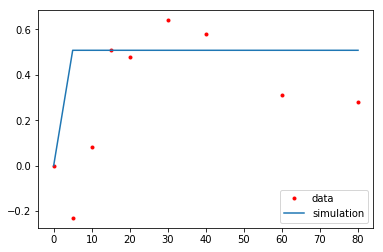

In [249]:
y_pred = get_predictions2(fit_params2.x)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred = get_predictions2(fit_params2.x)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

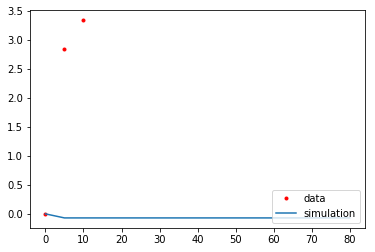

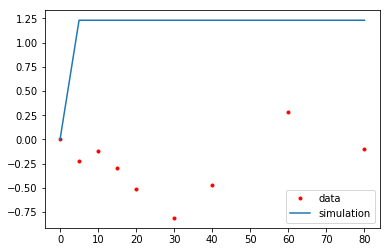

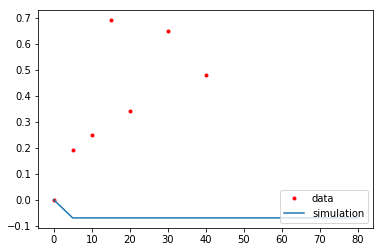

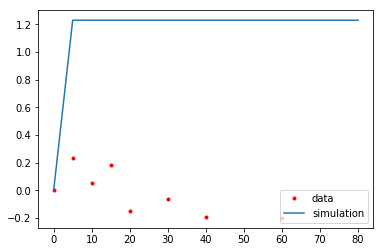

In [251]:
y_pred = get_predictions2(fit_params2.x)
for i in range(4, 8):
    real_data = gasch_data.iloc[:, 2:10].iloc[i,:]
    plt.plot(times, [0] + list(real_data), '.r', label="data")
    plt.plot(times, y_pred[:, i], '-', label="simulation")
    plt.legend(loc="lower right")
    plt.show()

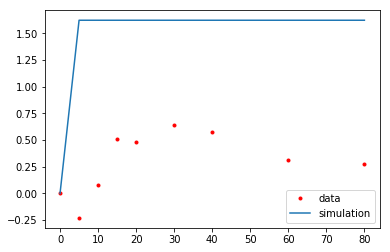

In [290]:
y_pred = get_predictions3(fit_params3.x)

real_data = gasch_data.iloc[:, 2:10].loc["HSF1"]
plt.plot(times, [0] + list(real_data), '.r', label="data")
plt.plot(times, y_pred[:, hsf_index], '-', label="simulation")
plt.legend(loc="lower right")
plt.show()

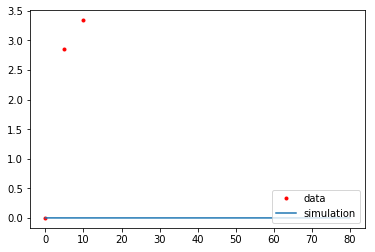

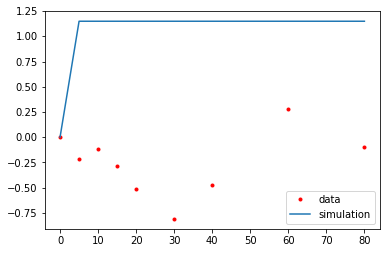

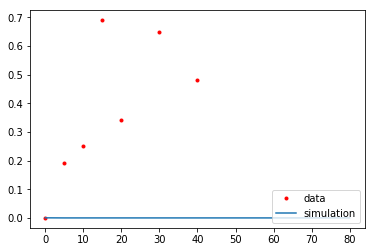

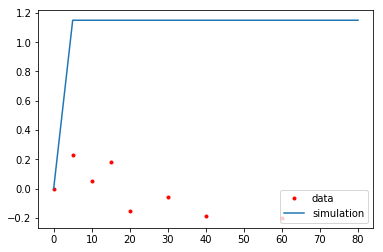

In [289]:
y_pred = get_predictions3(fit_params3.x)
for i in range(4, 8):
    real_data = gasch_data.iloc[:, 2:10].iloc[i,:]
    plt.plot(times, [0] + list(real_data), '.r', label="data")
    plt.plot(times, y_pred[:, i], '-', label="simulation")
    plt.legend(loc="lower right")
    plt.show()

In [205]:
error(np.array([0.0, 0.5, 0.3, 0.3, 0.1]), y_data, N, hss_indices, n_hss=1)

1.03

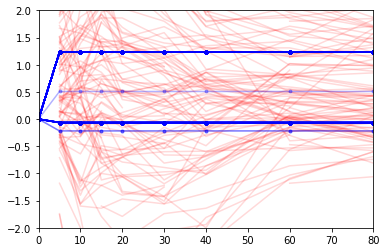

In [235]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-r', alpha=0.15)
plt.plot(times, y_pred, '.-b', alpha=0.3)
plt.xlim(0, 80)
plt.ylim(-2, 2)
plt.show()

In [254]:
np.concatenate((np.array([1,2]), np.array([3,4])))

array([1, 2, 3, 4])